# Signature Verification

## Import all Necessary Libraries

In [1]:
import os
import time
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import PIL
import PIL.ImageOps
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.utils
import torchvision.transforms as T

from torch import optim # will probably use RMS or Adam
from torch.optim import lr_scheduler # can adjust the learning rate based on the number of epochs


## Check GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.cuda.empty_cache()

Let's also check the current working directory.

In [4]:
print(os.getcwd())

C:\Users\Shakuntala Mitra\Desktop\myProjects\SigVer


## Config

In [5]:
class config():
    training_dir="./sign_data/train"
    training_csv="./sign_data/train_data.csv" # train set labels
    testing_csv="./sign_data/test_data.csv"
    testing_dir="./sign_data/test" # test set labels
    BATCH_SIZE = 8
    EPOCHS = 10
    IMG_SIZE = (105, 105)

In [6]:
Config = config()

In [7]:
training_dir="./sign_data/train"
training_csv="./sign_data/train_data.csv" # train set labels
testing_csv="./sign_data/test_data.csv"
testing_dir="./sign_data/test" # test set labels

In [8]:
DIR_PATH = './sign_data'

print(next(os.walk(DIR_PATH))[2])

['test_data.csv', 'train_data.csv']


## Define Utility Functions

In [9]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Check training set labels

In [10]:
train_df = pd.read_csv(training_csv)
train_df.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
8690,001/001_12.PNG,001/001_10.PNG,0
21270,059/06_059.png,059/05_059.png,0
12565,055/01_055.png,055/09_055.png,0
200,068/01_068.png,068/12_068.png,0
7011,024/02_024.png,024/12_024.png,0
3277,058/03_058.png,058/06_058.png,0
16404,052/02_052.png,052_forg/01_0106052.PNG,1
20566,032/07_032.png,032_forg/03_0120032.PNG,1
5539,044/08_044.png,044_forg/03_0211044.PNG,1
3450,026/07_026.png,026_forg/02_0125026.PNG,1


For each pair of images, 1 denotes the presence of a forgery, and 0 denotes a genuine pair of signatures.

## Loading Datasets

In [11]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L") #L mode means it is a single channel image - normally interpreted as greyscale.
        img1 = img1.convert("L")
        
        # Apply image transformations
        img0 = self.transform(img0)
        img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [12]:
# create transformed dataset using our new Dataset class

siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=T.Compose([T.Resize(Config.IMG_SIZE),
                                                             T.ToTensor()])
                                       )

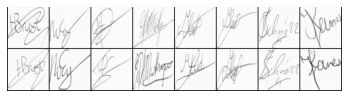

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [13]:
# check how the images are loading and if they're loading correctly

siamese_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)

dataiter = iter(siamese_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Building Siamese Network

In [14]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

## Loss Function (Contrastive Loss)

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Train the Model

In [16]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)

In [17]:
# Declare Siamese Network
net = SiameseNetwork().to(device)
# Declare Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [18]:
train_dataloader

In [19]:
# # define training function

# def train():
#     loss = []
#     Config = config()
#     for epoch in tqdm(range(0,Config.EPOCHS)): # let's put a progress bar here so we can see how many epochs we've made it thru
#         i = 0
#         for data in train_dataloader:
#             print(i)
#             i += 1

In [ ]:
model = train()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

  5%|████▏                                                                              | 1/20 [01:29<28:23, 89.66s/it]

724
725
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


In [19]:
# define training function

def train():
    loss = []
    Config = config()
    for epoch in range(0,Config.EPOCHS): # let's put a progress bar here so we can see how many epochs we've made it thru
        for i, data in tqdm(enumerate(train_dataloader,0)):
            img0, img1 , label = data
            img0, img1 , label = img0.to(device), img1.to(device), label.to(device)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [ ]:
# Train the model
model = train()

In [20]:
model = train()

2901it [05:55,  8.15it/s]
2it [00:00, 11.46it/s]

Epoch 0
 Current loss 1.756579875946045



2901it [05:24,  8.95it/s]
2it [00:00, 13.03it/s]

Epoch 1
 Current loss 1.242246389389038



2901it [34:50,  1.39it/s]
2it [00:00, 11.76it/s]

Epoch 2
 Current loss 1.07662034034729



2901it [05:23,  8.95it/s]
2it [00:00, 12.74it/s]

Epoch 3
 Current loss 0.8162011504173279



2901it [05:24,  8.93it/s]
2it [00:00, 12.29it/s]

Epoch 4
 Current loss 1.1190484762191772



2901it [3:21:17,  4.16s/it] 
2it [00:00, 12.42it/s]

Epoch 5
 Current loss 1.3876845836639404



2901it [14:58:10, 18.58s/it]   
2it [00:00, 11.26it/s]

Epoch 6
 Current loss 1.2267380952835083



2901it [07:31,  6.43it/s]
2it [00:00, 12.66it/s]

Epoch 7
 Current loss 1.1120072603225708



2901it [05:43,  8.44it/s]
2it [00:00, 13.16it/s]

Epoch 8
 Current loss 1.228623867034912



2901it [05:46,  8.38it/s]

Epoch 9
 Current loss 1.473667860031128



In [21]:
# save the model

torch.save(model.state_dict(), "./model_v1.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [21]:
#torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1734 MB |    1760 MB |    2812 MB |    1078 MB |\n|       from large pool |    1733 MB |    1759 MB |    2811 MB |    1078 MB |\n|       from small pool |       1 MB |       1 MB |       1 MB |       0 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1734 MB |    1760 MB |    2812 MB |    1078 MB |\n|       from large pool |    1733 MB |    1759 MB |

## Test Model Accuracy

In [20]:
# Load the saved model
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("./model_v1.pt"))

<All keys matched successfully>

In [21]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=T.Compose([T.Resize((105,105)),
                                                                      T.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

for i, data in tqdm(enumerate(test_dataloader,0)): 
    x0, x1, label = data
    concatenated = torch.cat((x0,x1),0)
                    
    output1,output2 = model(x0.to(device),x1.to(device))
    euclidian_distance = F.pairwise_distance(output1, output2)
                    
    if label==list_0:
        label="Original"
    else:
        label="Forged"
    
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(euclidian_distance.item(),label))
    counter=counter+1
    
    if counter ==20:
        break

In [ ]:
# accuracy check on test dataset!

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
  # oneshot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
    output1,output2 = model(x0.to(device),x1.to(device))
    res=torch.abs(output1.cuda() - output2.cuda())
    label=label[0].tolist()
    label=int(label[0])
    result=torch.max(res,1)[1][0][0][0].data[0].tolist()
    if label == result:
        correct=correct+1

    counter=counter+1
#   if counter ==20:
#      break
    
accuracy=(correct/len(test_dataloader))*100
print("Accuracy:{}%".format(accuracy))